In [1]:
# Dependencies
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fn
from torch.utils import data

import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize

import torch.utils.tensorboard as tensorboard
from torchvision.utils import make_grid

%matplotlib inline
import matplotlib.pyplot as plt

/Users/eeshandhekane/Desktop/mila-studies/phd/dev/pytorch-examples/venv/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
# Define transforms.
train_transform = Compose([
    ToTensor(),
    Normalize(mean=(0.5, ), std=(0.5, )),
    # RandomCrop(size=(28, 28)),
])
test_transform = Compose([
    ToTensor(),
    Normalize(mean=(0.5, ), std=(0.5, ))
])

In [3]:
# Create datasets and loaders.
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', download=True, train=True, transform=train_transform, target_transform=None
)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', download=True, train=False, transform=test_transform, target_transform=None
)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=True, num_workers=2)
idx_to_class: dict = {
    0: 'T-Shirt/Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

/Users/eeshandhekane/Desktop/mila-studies/phd/dev/pytorch-examples/venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
for idx, batch in enumerate(train_loader):
    print('idx: {}'.format(idx))
    # print('batch:\n{}'.format(batch))
    print('batch type: {}'.format(type(batch)))
    print('batch first element type:\n\t{}\nshape:\n\t{}'.format(type(batch[0]), batch[0].shape))
    print('batch second element type:\n\t{} and shape:\n\t{}'.format(type(batch[1]), batch[1].shape))
    break

imgs, labels = next(iter(train_loader))

idx: 0
batch type: <class 'list'>
batch first element type:
	<class 'torch.Tensor'>
shape:
	torch.Size([8, 1, 28, 28])
batch second element type:
	<class 'torch.Tensor'> and shape:
	torch.Size([8])


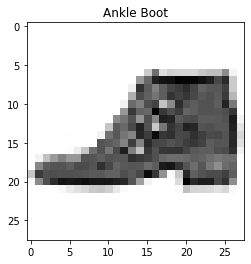

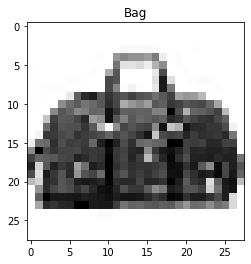

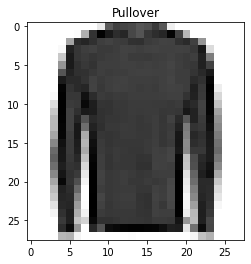

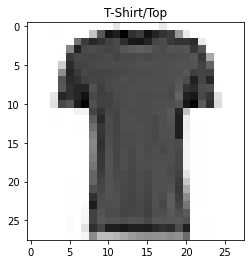

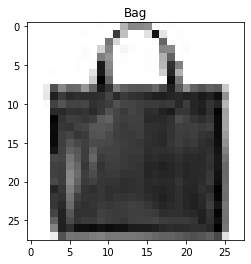

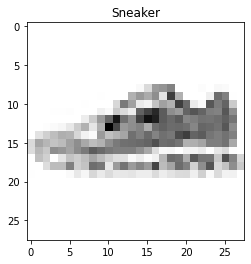

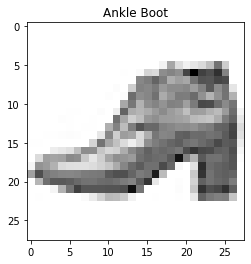

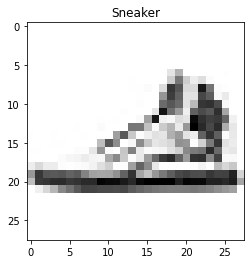

In [5]:
# noinspection PyUnusedLocal
def show(data_: torch.Tensor, idx_: int) -> None:
    r"""

    Parameters
    ----------
    data_:
        The torch tensor for the images.
        SHAPE: [<batch_size>, <num_channels>, <width>, <height>]
    idx_:
        The index/label of the image.

    Returns
    -------
    """
    fig = plt.figure()
    plt.imshow(data_.clone().detach().squeeze().numpy(), cmap='Greys')
    plt.title(idx_to_class[idx_])
    plt.show()

for idx in range(8):
    show(imgs[idx], int(labels[idx]))

In [6]:
# Logging to tensorboard.
writer = tensorboard.SummaryWriter(log_dir='./runs/example-9-tensorboard', comment='example writer')
writer.add_image(img_tensor=make_grid(imgs), tag='example batch of data')
writer.flush()

In [7]:
class Model(nn.Module):
    r"""LeNet basic model.
    """

    #
    def __init__(self):
        r"""The initializer.
        """
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=(5, 5), stride=(1, 1), bias=True
        )
        self.act1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1), bias=True
        )
        self.act2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(16*4*4, 120)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    #
    def forward(self, x):
        r"""Implements the forward pass.

        Parameters
        ----------
        x:
            The input image tensor.
            SHAPE: [<batch_size>, <in_channels=1>, <width=28>, <height=28>].

        Returns
        -------
        out:
            The processed logits tensor.
            SHAPE: [<batch_size>, <out_dim=10>].
        """
        y1 = self.pool1(self.act1(self.conv1(x)))
        y2 = self.pool2(self.act2(self.conv2(y1)))
        y3 = y2.view(y2.shape[0], -1)
        y4 = self.act3(self.fc1(y3))
        y5 = self.act4(self.fc2(y4))
        out = self.fc3(y5)
        return out

In [8]:
model = Model()
print('model:\n{}'.format(model))


model:
Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
with torch.no_grad():
    imgs, labels = next(iter(train_loader))
    logits = model(imgs)
    print('logits shape: {}'.format(logits.shape))

logits shape: torch.Size([8, 10])


In [ ]:
# Define loss.
def compute_loss(
        logits: torch.Tensor, true_labels: torch.Tensor
) -> torch.Tensor:
    r"""Computes the loss for a batch.

    Parameters
    ----------
    logits:
        The tensor for logits of given input.
        SHAPE: [<batch_size>, <output_dim=10>].

    true_labels:
        The tensor of true labels.
        SHAPE: [<batch_size>, <output_dim=10>].

    Returns
    -------
    loss:
        The loss scalar.
        SHAPE: [].
    """
    pass
